In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm import tqdm
import sys
import matplotlib as mpl

#insert path
sys.path.insert(0, '../methods/')

sys.modules.pop('generate_syn_data', None)
from generate_syn_data import *

sys.modules.pop('ARWQE', None)
from ARWQE import *

sys.modules.pop('plots', None)
from plots import *

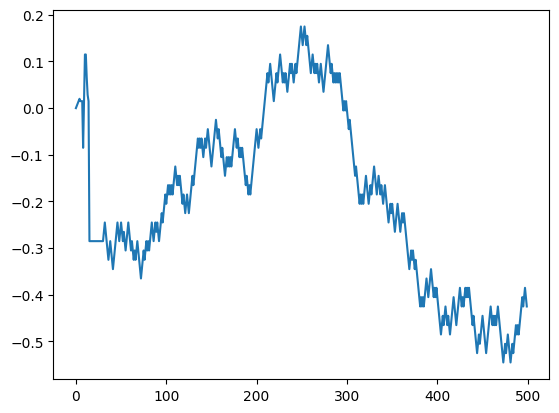

10it [00:04,  2.31it/s]


In [137]:
N = 1000
alpha =0.1; delta = 0.1; gamma=1
rho = 0.99; 

num_periods = N
num_trials = 10

#NOTE: uncomment to change shift patterns
#beta_1 = 2 * np.sin(np.linspace(0, 5*np.pi, num_periods)) + 5
#beta_1 = np.ones(num_periods)
beta_1 = generate_true_means(num_periods-1, 2)
beta_2 = np.ones(num_periods)
plt.plot(beta_1)
plt.show()
beta = np.column_stack((beta_1, beta_2))
variance_y = 1; meanX = 1

np.random.seed(6)

#B_arr is for val set
B_arr = np.random.randint(low=1, high=2, size=num_periods)
B_arr_starts = np.arange(num_periods)
B_arr_ends = np.cumsum(B_arr) - 1

fixed_windows = [1, 4, 16, 64, 256, 1024]

cdf_dict = create_empty_dict(fixed_windows, num_trials)
interval_dict = create_empty_dict(fixed_windows, num_trials)

train_lag = 10
arw_cdf = np.zeros((num_trials, num_periods-train_lag))
nex_cdf = np.zeros((num_trials, num_periods-train_lag))
arw_width = np.zeros((num_trials, num_periods-train_lag))
nex_width = np.zeros((num_trials, num_periods-train_lag))

seeds = np.arange(num_trials) + 2024

for (trial, seed) in tqdm(enumerate(seeds)):
    
    np.random.seed(seed)

    X, Y = generate_linreg_data(meanX, B_arr, beta, variance_y)
        
    for t in range(10, num_periods):
        
        #Compare with splitCP_LS
        weights=rho**(np.arange(t,0,-1))
        y_interval, beta_hat_nex = splitCP_LS(X[:t,:],Y[:t],X[t,:],alpha,weights=weights)

        nex_y_low = y_interval[0]; nex_y_upp = y_interval[1]
        nex_q = (nex_y_upp - nex_y_low)/2
        #our method
        inds_odd = np.arange(1,int(np.ceil(t/2)*2-1),2)
        inds_even = np.arange(2,int(np.floor(t/2)*2),2)
        
        X_tr = X[:t, :][inds_odd]; Y_tr = Y[:t][inds_odd]
        X_val = X[:t, :][inds_even]; Y_val = Y[:t][inds_even]

        beta_hat, S_t = fit_LS_get_scores(X_tr, Y_tr, X_val, Y_val)

        B_val_t = np.ones(len(Y_val)).astype(int)

        khat, qt_khat, qtk_all = ARWQE(S_t, B_val_t, alpha, delta, gamma)

        #approximate by generating ~1000 X, Y from this period 
        # and calculate coverage of prediction set
        dimX = X_tr.shape[1]

        np.random.seed(18)

        X_test = generate_multinomial_X(meanX, dimX, 1000)
        y_hat = X_test @ beta_hat.T
        y_hat_nex = X_test @ beta_hat_nex.T
        mu_test = X_test @ beta[t].T
        Y_test = mu_test + np.random.normal(0, variance_y, 1000)  

        coverage_nex = monte_carlo_coverage(y_hat_nex, nex_q, Y_test)
        coverage_ARW = monte_carlo_coverage(y_hat, qt_khat, Y_test)

        arw_width[trial, t-train_lag] = 2*qt_khat
        nex_width[trial, t-train_lag] = 2*nex_q

        arw_cdf[trial, t-train_lag] = coverage_ARW
        nex_cdf[trial, t-train_lag] = coverage_nex

        #cdf_dict['ARW'][trial].append(np.abs(coverage_ARW - 1+alpha))
        cdf_dict['ARW'][trial].append(coverage_ARW)
        interval_dict['ARW'][trial].append(2*qt_khat)

        #baseline: take quantile of fixed k
        #qtk_fixed = compute_qtk(S_t, np.array(fixed_windows), B_arr_t, alpha)
        for ik, k in enumerate(fixed_windows):
            log2k = int(np.log2(k))
            qtk = qtk_all[min(log2k, len(qtk_all)-1)]
            coverage_k = monte_carlo_coverage(y_hat, qtk, Y_test)
            cdf_dict[f'Val_{k}'][trial].append(coverage_k)
            interval_dict[f'Val_{k}'][trial].append(2*qtk)

    #plot k_hat_all
    #plt.plot(k_hat_all)

In [154]:
burnin = 100
print('ARW mae:', np.mean(np.mean(np.abs(arw_cdf[:, burnin:]-1+alpha), axis=0)))
print('NEX mae:', np.mean(np.mean(np.abs(nex_cdf[:, burnin:]-1+alpha), axis=0)))
print('ARW mean width:', np.mean(np.mean(arw_width[:, burnin:], axis=0)))
print('NEX mean width:', np.mean(np.mean(nex_width[:, burnin:], axis=0)))
print('ARW mean cov:', np.mean(np.mean(arw_cdf[:, burnin:], axis=0)))
print('NEX mean cov:', np.mean(np.mean(nex_cdf[:, burnin:], axis=0)))

#plt.plot(np.mean(nex_cdf, axis=0), label='nEX')

ARW mae: 0.02089307692307693
NEX mae: 0.031021794871794874
ARW mean width: 3.5013203150071983
NEX mean width: 3.777424866035967
ARW mean cov: 0.8996587179487179
NEX mean cov: 0.9224217948717949


[0.10459635 0.41188059 0.13701682 0.08471471 0.12341306 0.11071012
 0.10966094]


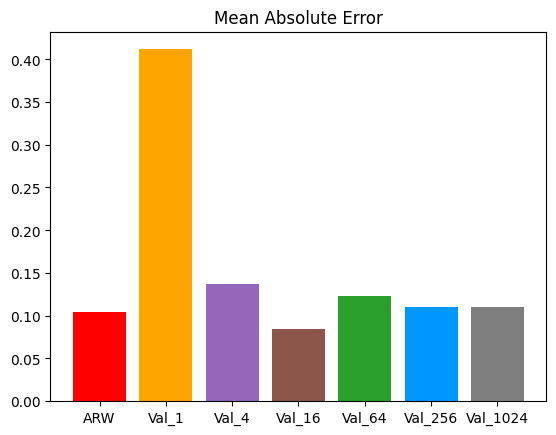

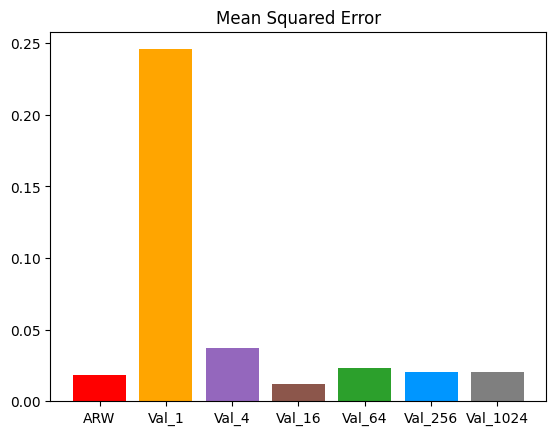

In [58]:
methods = ['ARW'] + [f'Val_{k}' for k in fixed_windows]
cdf_array, mae_array, mae, se_ae, mse_array, mse, se_mse \
    = summarize_cdf_dict(methods, num_trials, num_periods-50, cdf_dict, alpha)
print(mae)

In [88]:
# split conformal prediction with least squares
def splitCP_LS(X,Y,x,alpha,weights=[],tags=[]):
    # weights are used for computing quantiles for the prediction interval
    # tags are used as weights in weighted least squares regression
    n = len(Y)
    
    if(len(weights)==0):
        weights = np.ones(n+1)
    if(len(weights)==n):
        weights = np.r_[weights,1]
    
    # odd data points for training, even for calibration
    inds_odd = np.arange(1,int(np.ceil(n/2)*2-1),2)
    inds_even = np.arange(2,int(np.floor(n/2)*2),2)

    # train model
    betahat = np.linalg.solve(X[inds_odd].T.dot(X[inds_odd]),  X[inds_odd].T.dot(Y[inds_odd]))
    
    # compute residual quantile on calibration set
    weights_calib = weights[inds_even] / (np.sum(weights[inds_even])+weights[-1])

    if(np.sum(weights_calib) >= 1-alpha):
        R = np.abs(Y[inds_even] - X[inds_even].dot(betahat))
        ord_R = np.argsort(R)
        ind_thresh = np.min(np.where(np.cumsum(weights_calib[ord_R])>=1-alpha))
        calib_thresh = np.sort(R)[ind_thresh]
    else:
        calib_thresh = np.inf
    
    y_PI = np.array([x.T.dot(betahat)-calib_thresh,x.T.dot(betahat)+calib_thresh])
    return y_PI, betahat
